# 1. Introdução
Antes de entrar na criação do modelo, vamos entender alguns pontos que vão ajudar a compreender o que está acontecendo na análise das métricas utilizando a matriz de confusão.

A matriz de confusão nos permite analisar de forma detalhada o comportamento do nosso classificador, e para isso ela divide os resultados em quatro tipos:

True Positive(TP): Se refere aos casos que o modelo previu corretamente a classe positiva.

True Negative(TN): Se refere aos casos que o modelo previu corretamente a classe negativa.

False Positivo(FP): Se refere aos casos onde o modelo previu que era de uma classe positiva mas na verdade era da classe negativa.

False Negative(FN): Se refere aos casos onde o modelo previu que era de uma classe negativa mas na verdade era da classe positiva.

Para exemplificar uma matriz de confusão em um problema binário, segue abaixo um exemplo.

1*EMF8-8fZRjnuMRVnsEMDLg.png

Métricas
Essas métricas são utilizadas para visualizar o comportamento do classificador e podemos responder algumas perguntas sobre o classificador.

Accuracy: Qual a porcentagem de acertos do nosso classificador?

 $$ \frac{TP+FP}{TP+TN+FP+FN} $$
Precision: Quando classifiquei como correto, quantos realmente estavam corretos?

 $$\frac{TP}{TP+FP}$$
Recall: Com que frequência o classificador classifica os exemplos de uma classe?

 $$\frac{TP}{TP+FN}$$
F1 Score: É uma métrica que combina Recall e Precision com uma média harmônica, e indica a qualidade geral do modelo.

 $$\frac{2*Recall*Precision}{Recall + Precision} = \frac{\frac{1}{Precision} + \frac{1}{Recall}}{2}$$
# 2. Criando o baseline 
Para a criação de um modelo inicial para nos basearmos, iremos seguir algumas etapas.

Feature Engineering
Modeling
Performance Analysis

In [434]:
# importando bibliotecas
import pandas as pd #Manipulação do dataframe
import metrics # Importando dataset e metricas
import numpy as np # Biblioteca de calculo cientifico
import matplotlib.pyplot as plt # Biblioteca de visualização
import eli5 # Biblioteca que depurar algoritmos classificadores
import warnings # Biblioteca de warnings
import sklearn.metrics # Função básicas de estatíticas
from sklearn import tree # Biblioteca do modelo de árvore de decisão
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold # Biblioteca de separação em treino e teste e validação cruzada
from sklearn.metrics import confusion_matrix # Biblioteca que gera matriz de confusão
from sklearn.neural_network import MLPClassifier # Métodos de redes neurais para classificação
from eli5.sklearn import PermutationImportance # Metodo para calcular feature importance de algoritmo 'caixa preta'
from eli5.permutation_importance import get_score_importances # Método que retorna as pontuações das caracteristicas
from sklearn.utils.multiclass import unique_labels # Biblioteca geradora das labels
from pprint import pprint # Biblioteca para imprimir de maneira mais elegante as estruturas de dados
from IPython.core.display import HTML
from matplotlib._pylab_helpers import Gcf
from IPython.core.pylabtools import print_figure 
from base64 import b64encode
import seaborn as sns


warnings.filterwarnings("ignore")#desabilitar os warnings
#Configurar o tamanho das imagens
%matplotlib inline

In [435]:
# Criando o dataframe
df = pd.read_csv('dataset.csv')
df.head()

,id,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,0,0,1,1,0,1,0,...,m,Others,no,no,Jordan,no,5,4-11 years,Parent,NO
1,2,1,1,0,0,1,1,0,1,0,...,m,Middle Eastern,no,no,Jordan,no,5,4-11 years,Parent,NO
2,3,1,1,0,0,0,1,1,1,0,...,m,?,no,no,Jordan,yes,5,4-11 years,?,NO
3,4,0,1,0,0,1,1,0,0,0,...,f,?,yes,no,Jordan,no,4,4-11 years,?,NO
4,5,1,1,1,1,1,1,1,1,1,...,m,Others,yes,no,United States,no,10,4-11 years,Parent,YES


In [436]:
# Função de plotagem da matriz de confusão
def plot_confusion_matrix(y_test,result,cmap = plt.cm.Blues):
    # Matriz de confusão
    cm = confusion_matrix(y_test,result)
    classe = unique_labels(y_test,result)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # Queremos mostrar todos os momentos
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ...e rotule-os com as respectivas entradas da lista
           xticklabels=classe, yticklabels=classe,
           title= 'Matriz de confusão',
           ylabel='Rótulo real',
           xlabel='Rótulo previsto')

    # Gire os rótulos de escala e defina seu alinhamento.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Passe pelas dimensões dos dados e crie anotações de texto.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# 2.1 Feature Engineering
Nessa etapa será relacionado as features que vamos utilizar no modelo baseline.

In [437]:
# Selecionando colunas com os traços comportamentais.
columns = ['A{}_Score'.format(i) for i in range(1,11)]

columns

['A1_Score',
 'A2_Score',
 'A3_Score',
 'A4_Score',
 'A5_Score',
 'A6_Score',
 'A7_Score',
 'A8_Score',
 'A9_Score',
 'A10_Score']

In [438]:
# Separando em variáveis preditoras X e alvo da nossa predição Y
X = df[columns]
X

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score
0,1,1,0,0,1,1,0,1,0,0
1,1,1,0,0,1,1,0,1,0,0
2,1,1,0,0,0,1,1,1,0,0
3,0,1,0,0,1,1,0,0,0,1
4,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
287,1,1,1,1,1,1,1,1,1,1
288,1,0,0,0,1,0,1,0,0,1
289,1,0,1,1,1,1,1,0,0,1
290,1,1,1,0,1,1,1,1,1,1


In [439]:
Y = df['Class/ASD']
# Para melhor entendimento do dataset, iremos renomear os valores de Y
Y = Y.replace({'NO':'Sem_Autismo','YES':'Autismo'})
Y

0      Sem_Autismo
1      Sem_Autismo
2      Sem_Autismo
3      Sem_Autismo
4          Autismo
          ...     
287        Autismo
288    Sem_Autismo
289        Autismo
290        Autismo
291    Sem_Autismo
Name: Class/ASD, Length: 292, dtype: object

# 2.2. Modeling e Analysis
Nessa etapa aplicaremos o modelo que foi selecionado e com isso a contrução das predições do nosso modelo baseline.

Modelo selecionado: Decision Tree
Motivo: Fácil compreensão.

In [440]:
# Criação do modelo
baseline = MLPClassifier(solver='adam',
                          alpha = 1e-5,
                          hidden_layer_sizes=(15,10),
                          random_state=1,
                          max_iter=150)
print(baseline)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(15, 10), learning_rate='constant',
              learning_rate_init=0.001, max_iter=150, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)


# 2.2.1. Treino e Teste
Nessa parte testarei duas técnicas.

Separando em treino e teste e Validação cruzada


In [441]:
# Separando em treino e teste
x_train,x_test,y_train,y_test = train_test_split(X,Y,
                                                 test_size = 0.4,
                                                 random_state = 40)

# Treinando o modelo
test1 = baseline.fit(x_train,y_train)
perm = PermutationImportance(baseline).fit(x_test, y_test)
results = test1.predict(x_test)
y_pred = results
table = pd.DataFrame(list(zip(y_test, y_pred)), columns=['y_test', 'y_pred'])
table.head()

,y_test,y_pred
0,Sem_Autismo,Sem_Autismo
1,Sem_Autismo,Sem_Autismo
2,Autismo,Autismo
3,Autismo,Autismo
4,Autismo,Autismo


In [442]:
print('Exemplos de Falso Negativos')
table[(table.y_test == 'Autismo') & (table.y_pred == 'Sem_Autismo')]

Exemplos de Falso Negativos


,y_test,y_pred
21,Autismo,Sem_Autismo
40,Autismo,Sem_Autismo
58,Autismo,Sem_Autismo
59,Autismo,Sem_Autismo
72,Autismo,Sem_Autismo
112,Autismo,Sem_Autismo


In [443]:
print('Exemplos de Falso Positivos')
table[(table.y_test == 'Sem_Autismo') & (table.y_pred == 'Autismo')]

Exemplos de Falso Positivos


,y_test,y_pred
12,Sem_Autismo,Autismo
17,Sem_Autismo,Autismo
39,Sem_Autismo,Autismo
43,Sem_Autismo,Autismo
52,Sem_Autismo,Autismo
57,Sem_Autismo,Autismo
60,Sem_Autismo,Autismo
67,Sem_Autismo,Autismo
84,Sem_Autismo,Autismo
85,Sem_Autismo,Autismo


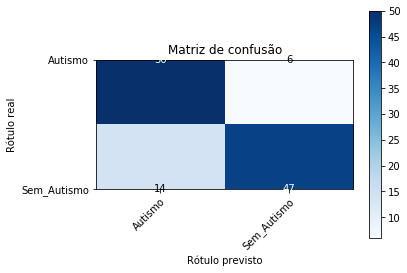

In [444]:
# Informações do modelo
plot_confusion_matrix(y_test,results)
metrics1 = metrics.classification_report(y_test, y_pred)
plt.show()

In [445]:
print("Métricas do modelo que implementamos: \n")
pprint(metrics1)
print()

print("Métricas já embutidas no sklearn: \n")
print(sklearn.metrics.classification_report(y_test, y_pred))

Métricas do modelo que implementamos: 

{'accuracy': 0.7901234567901234,
 'f1': 0.8333333333333334,
 'precision': 0.78125,
 'recall': 0.8928571428571429}

Métricas já embutidas no sklearn: 

              precision    recall  f1-score   support

     Autismo       0.78      0.89      0.83        56
 Sem_Autismo       0.89      0.77      0.82        61

    accuracy                           0.83       117
   macro avg       0.83      0.83      0.83       117
weighted avg       0.84      0.83      0.83       117



# 2.2.2. K-Fold Cross Validation
A validação cruzada é uma técnica utilizada para evitar que o modelo se "acostume" com nossa base de dados e com isso não generalize novas informações.

# 2.2.3 Funcionamento:

Seu funcionamento se da em "dividir e testar", ou seja, os nossos dados são divididos em X partes, em cada uma dessas partes é novamente dividida em treino e teste e é testada então as partes e esse processo é repetido até que o modelo seja testado e treinado em todas essas partes e no final se calcula a métrica dos testes, dessa forma:

In [446]:
# Validação cruzada k-fold
#kf  = KFold(n_splits = 5, shuffle = True, random_state = 1)
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)
print(skf)

StratifiedKFold(n_splits=5, random_state=1, shuffle=True)


Métrica do Sklearn 
  
              precision    recall  f1-score   support

     Autismo       0.91      1.00      0.95        29
 Sem_Autismo       1.00      0.90      0.95        31

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60

Métrica implementada 
  
{'accuracy': 0.9411764705882353, 'precision': 0.90625, 'recall': 1.0, 'f1': 0.9508196721311475}
Métrica do Sklearn 
  
              precision    recall  f1-score   support

     Autismo       0.89      0.89      0.89        28
 Sem_Autismo       0.90      0.90      0.90        30

    accuracy                           0.90        58
   macro avg       0.90      0.90      0.90        58
weighted avg       0.90      0.90      0.90        58

Métrica implementada 
  
{'accuracy': 0.7777777777777778, 'precision': 0.8928571428571429, 'recall': 0.8928571428571429, 'f1': 0.8928571428571429}
Métrica do Sklearn 
  
         

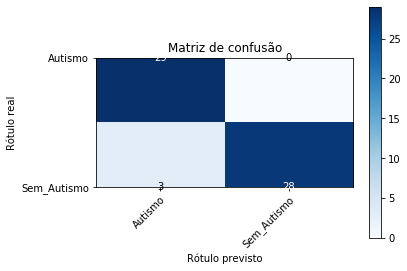

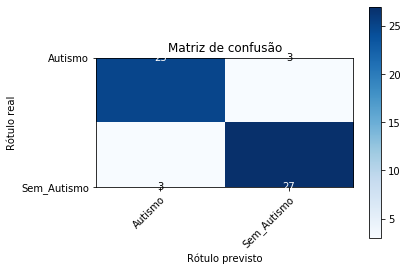

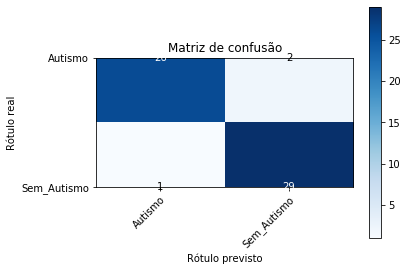

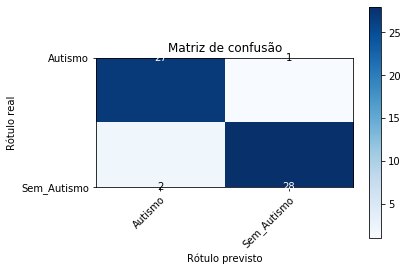

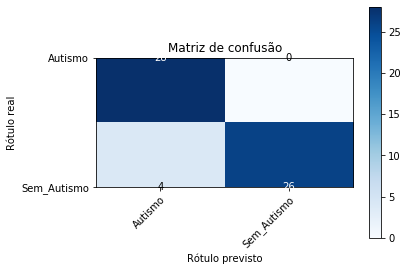

In [447]:
metricas = []
i = 0
# Separando as bases de treino e teste
for train,test in skf.split(X,Y):
    #print(train)
    #print(test)
    # Dicionaro de treino
    train_x, test_x = X.iloc[train], X.iloc[test]
    train_y, test_y = Y.iloc[train], Y.iloc[test]
    aux = baseline.fit(train_x,train_y)
    rst = aux.predict(test_x)
    metricas.append(metrics.classification_report(test_y, rst))
    print('Métrica do Sklearn \n  \n{}'.format(sklearn.metrics.classification_report(test_y, rst)))
    print('Métrica implementada \n  \n{}'.format(metricas[i]))
    plot_confusion_matrix(test_y,rst)
    i+=1

In [448]:

# Calculo da Média e Desvio padrão das métricas
ac = np.array([metricas[x]['accuracy'] for x in range(5)])
pc = np.array([metricas[x]['precision'] for x in range(5)])
rc = np.array([metricas[x]['recall'] for x in range(5)])
f1 = np.array([metricas[x]['f1'] for x in range(5)])

# Média e devio padrão
me_ac = np.mean(ac)
std_ac = np.std(ac)

print('Accuracy - média: {} e desvio padrão:: {}'.format(me_ac,std_ac))

me_pc = np.mean(pc)
std_pc = np.std(pc)

print('Precision - média: {} e desvio padrão:: {}'.format(me_pc,std_pc))

me_rc = np.mean(rc)
std_rc = np.std(rc)

print('Recall - média: {} e desvio padrão:: {}'.format(me_rc,std_rc))

me_f1 = np.mean(f1)
std_f1 = np.std(f1)

print('F1 Score - média: {} e desvio padrão:: {}'.format(me_f1,std_f1))

Accuracy - média: 0.8714200831847891 e desvio padrão:: 0.06540548264736645
Precision - média: 0.9136209177157453 e desvio padrão:: 0.03070801112491106
Recall - média: 0.9571428571428571 e desvio padrão:: 0.041649656391752124
F1 Score - média: 0.9339666229657603 e desvio padrão:: 0.021382217994398572


# 3. Feature Importance
Utilizar todos os atributos ao nosso alcance nem sempre é uma boa ideia, dependendo do problema isso não vai ficar legal. Então, para descobrir quais são as melhores features para criar o nosso modelo, é necessário aplicar algumas técnicas como: Qui², Importancia Gini ou Redução média da impureza, Importancia da permutação ou Redução média na precisão.

No nosso caso o modelo da biblioteca Sklearn, é baseado na Redução média da impureza.

In [449]:
#Transformando em dataframe
to_graph = eli5.explain_weights(perm,feature_names=columns)
df_feature_importance = eli5.formatters.format_as_dataframe(to_graph)
df_feature_importance

,feature,weight,std
0,A1_Score,6.495726e-02,0.031797
1,A4_Score,5.128205e-02,0.019490
2,A9_Score,3.931624e-02,0.013887
3,A10_Score,2.735043e-02,0.017433
4,A7_Score,1.880342e-02,0.013675
5,A3_Score,6.837607e-03,0.006396
6,A8_Score,2.220446e-17,0.005406
7,A6_Score,-3.418803e-03,0.006838
8,A5_Score,-6.837607e-03,0.021213
9,A2_Score,-1.367521e-02,0.004187


Text(0.5, 0, 'Importâncias')

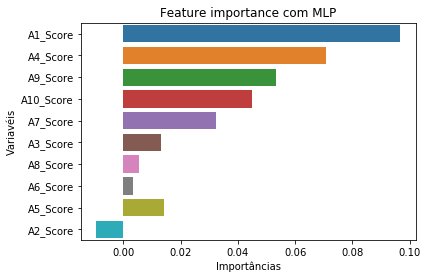

In [450]:
plt.title("Feature importance com MLP")
sns.barplot(x=df_feature_importance['weight']+df_feature_importance['std'],y=df_feature_importance['feature'])
plt.ylabel("Variavéis")
plt.xlabel("Importâncias")